#### Imports
Loading required libraries

In [1]:
import warnings; warnings.filterwarnings("ignore")
from models.preprocessing import utils
from models.stats.utils import get_time_slice, time_sliced_stats
from models.stats.plot import plot_masked_tfr
import mne; mne.utils.set_log_level('error')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Files
Select and load files, compute grand average

In [2]:
d = "../../data/reinhartlab/multimodal/cg/Spectral Power/Aggregate/"
ext = "-tfr.h5"
#TODO: select valid subjects only
box = utils.select_dataset(d,ext);box

In [8]:
stim_files = [d+f+ext for f in utils.get_selection(box) if "stimulus" in f]
resp_files = [d+f+ext for f in utils.get_selection(box) if "response" in f]
fdbk_files = [d+f+ext for f in utils.get_selection(box) if "feedback" in f]

stim_tfrs = [mne.time_frequency.read_tfrs(f)[0] for f in stim_files]
resp_tfrs = [mne.time_frequency.read_tfrs(f)[0] for f in resp_files]
fdbk_tfrs = [mne.time_frequency.read_tfrs(f)[0] for f in fdbk_files]

stim_avg = mne.grand_average([s.average() for s in stim_tfrs])
resp_avg = mne.grand_average([r.average() for r in resp_tfrs])
fdbk_avg = mne.grand_average([f.average() for f in fdbk_tfrs])

In [150]:
#intervals = [z for z in zip(np.round([(r*.1)+.001 for r in range(20)],3),np.round([(r*.1)+.1 for r in range(20)],3))]
#stim_T,stim_m = time_sliced_stats(stim_tfrs,intervals=intervals,p_threshold=.01)
#fdbk_T,fdbk_m = time_sliced_stats(fdbk_tfrs,intervals=intervals,p_threshold=.01)
intervals = [z for z in zip(np.round([(r*.1-1) for r in range(10)],3),np.round([(r*.1-1)+.099 for r in range(10)],3))] + \
[z for z in zip(np.round([(r*.1)+.001 for r in range(10)],3),np.round([(r*.1)+.1 for r in range(10)],3))]
respvsresp_T,respvsresp_m = time_sliced_stats(resp_tfrs,baseline=get_time_slice(resp_tfrs,-1.1,-1.001),intervals=intervals,p_threshold=.01)
respvsstim_T,respvsstim_m = time_sliced_stats(resp_tfrs,baseline=get_time_slice(stim_tfrs,-.1,-.001),intervals=intervals,p_threshold=.01)

### Stimulus-locked, all conditions and channels
We observe
* Early, short
        - increased theta (5-7Hz, 100-400ms)
        - decreased low gamma (35-60Hz, 100-300ms & 400-700ms)
* Followed by
        - decreased alpha (8-13Hz, 400-1000ms)
        - decreased high beta (20-30Hz, 400-1200ms)
        - Decreased high gamma (60-100+Hz, 400-1400ms)

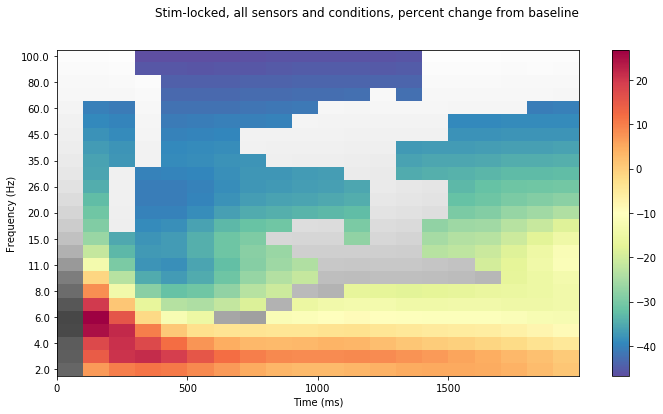

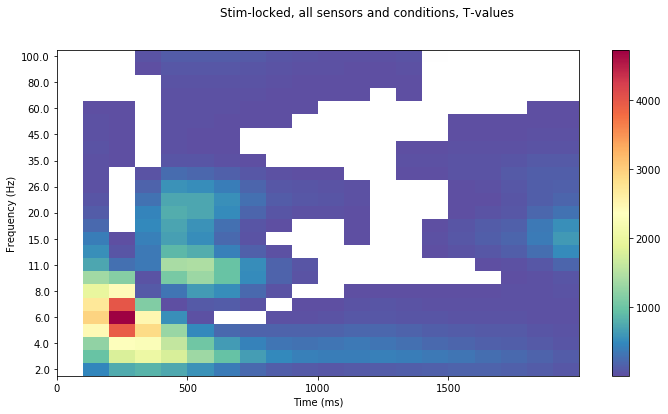

In [153]:
step = 2; freqs=stim_tfrs[0].freqs
xticks = [r for r in range(0,len(freqs),step)]
intervals = [z for z in zip(np.round([(r*.1)+.001 for r in range(20)],3),np.round([(r*.1)+.1 for r in range(20)],3))]
data = np.power(10,np.vstack([np.nanmean(stim_avg.copy().crop(t[0],t[1]).data,-1) for t in intervals]).T)*100-100

fig,ax = plt.subplots(1,1,figsize=(12,6))
im = plot_masked_tfr(data,stim_m,ax,labels={'y':(xticks,freqs[::step]),'x':([-.5,4.5,9.5,14.5],[0,500,1000,1500])},kwargs={'aspect':.5})
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (ms)")
fig.suptitle("Stim-locked, all sensors and conditions, percent change from baseline")
fig.colorbar(im, ax=ax);

fig,ax = plt.subplots(1,1,figsize=(12,6))
im = plot_masked_tfr(stim_T,stim_m,ax,labels={'y':(xticks,freqs[::step]),'x':([-.5,4.5,9.5,14.5],[0,500,1000,1500])},kwargs={'aspect':.5})
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (ms)")
fig.suptitle("Stim-locked, all sensors and conditions, T-values")
fig.colorbar(im, ax=ax);

### Response-locked, all conditions and channels
With (-1.1,-1) response-locked baseline
* Immediately preceding response
        - Slight decrease in alpha (7-13Hz, -500-0ms)
        - Larger decrease in high beta (20-26Hz, -500-0ms)
        - Large decrease in high gamma (50-100Hz, -500-0ms)
        - Significant, very small change in delta (2-4Hz, -500ms onwards)

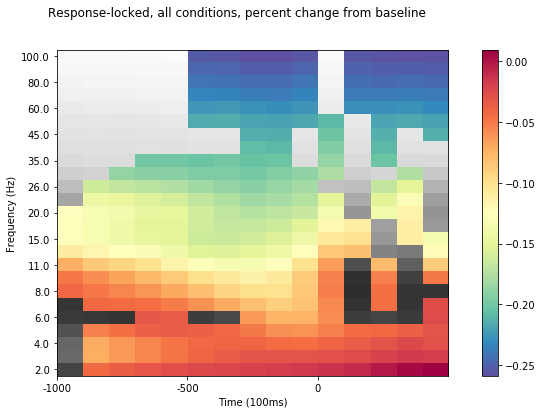

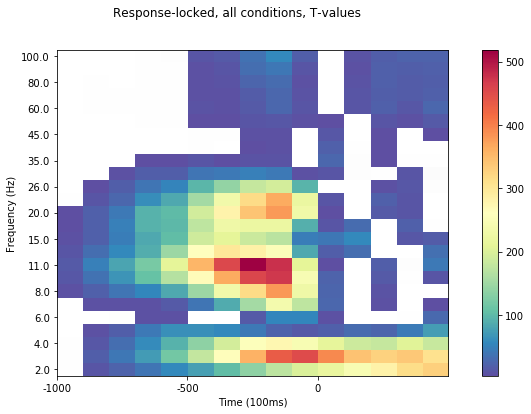

In [174]:
step = 2; freqs=resp_tfrs[0].freqs
ticks = [r for r in range(0,len(freqs),step)]
ts = (0,15)
intervals = [z for z in zip(np.round([(r*.1-1) for r in range(10)],3),np.round([(r*.1-1)+.099 for r in range(10)],3))] + \
[z for z in zip(np.round([(r*.1)+.001 for r in range(10)],3),np.round([(r*.1)+.1 for r in range(10)],3))]
intervals = intervals[ts[0]:ts[1]]
data = np.vstack([np.nanmean(resp_avg.copy().crop(t[0],t[1]).data,-1) for t in intervals]).T

# TODO: switch baselines for voltage-based data
# data = (data+1)-(np.nanmean(stim_avg.copy().crop(-.1,0).data,-1)/np.nanmean(resp_avg.copy().crop(-1.1,-1).data,-1)).T
fig,ax = plt.subplots(1,1,figsize=(12,6))
im = plot_masked_tfr(data,respvsresp_m[:,ts[0]:ts[1]],ax,labels={'y':(ticks,freqs[::step]),'x':([-.5,4.5,9.5],[-1000,-500,0])},kwargs={'aspect':.5})
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (100ms)")
fig.suptitle("Response-locked, all conditions, percent change from baseline")
fig.colorbar(im, ax=ax);

fig,ax = plt.subplots(1,1,figsize=(12,6))
im = plot_masked_tfr(respvsresp_T[:,ts[0]:ts[1]],respvsresp_m[:,ts[0]:ts[1]],ax,labels={'y':(ticks,freqs[::step]),'x':([-.5,4.5,9.5],[-1000,-500,0])},kwargs={'aspect':.5})
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (100ms)")
fig.suptitle("Response-locked, all conditions, T-values")
fig.colorbar(im, ax=ax);

### Response-locked, all conditions and channels
With (-.1,0) stimulus-locked baseline

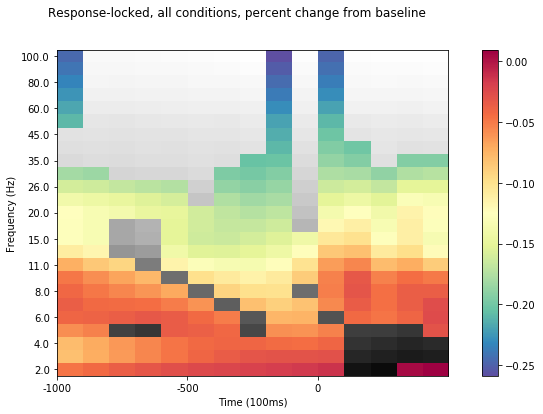

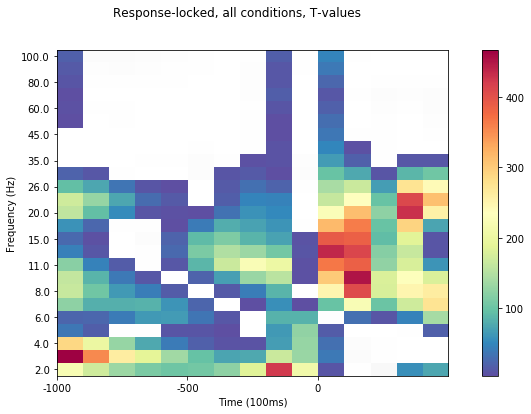

In [173]:
step = 2; freqs=resp_tfrs[0].freqs
ticks = [r for r in range(0,len(freqs),step)]
ts = (0,15)
intervals = [z for z in zip(np.round([(r*.1-1) for r in range(10)],3),np.round([(r*.1-1)+.099 for r in range(10)],3))] + \
[z for z in zip(np.round([(r*.1)+.001 for r in range(10)],3),np.round([(r*.1)+.1 for r in range(10)],3))]
intervals = intervals[ts[0]:ts[1]]
data = np.vstack([np.nanmean(resp_avg.copy().crop(t[0],t[1]).data,-1) for t in intervals]).T

# TODO: switch baselines for voltage-based data
# data = (data+1)-(np.nanmean(stim_avg.copy().crop(-.1,0).data,-1)/np.nanmean(resp_avg.copy().crop(-1.1,-1).data,-1)).T
fig,ax = plt.subplots(1,1,figsize=(12,6))
im = plot_masked_tfr(data,respvsstim_m[:,ts[0]:ts[1]],ax,labels={'y':(ticks,freqs[::step]),'x':([-.5,4.5,9.5],[-1000,-500,0])},kwargs={'aspect':.5})
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (100ms)")
fig.suptitle("Response-locked, all conditions, percent change from baseline")
fig.colorbar(im, ax=ax);

fig,ax = plt.subplots(1,1,figsize=(12,6))
im = plot_masked_tfr(respvsstim_T[:,ts[0]:ts[1]],respvsstim_m[:,ts[0]:ts[1]],ax,labels={'y':(ticks,freqs[::step]),'x':([-.5,4.5,9.5],[-1000,-500,0])},kwargs={'aspect':.5})
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (100ms)")
fig.suptitle("Response-locked, all conditions, T-values")
fig.colorbar(im, ax=ax);

### Feedback-locked, all conditions and channels
    - Late increased low beta (to alpha) (900-1500ms)

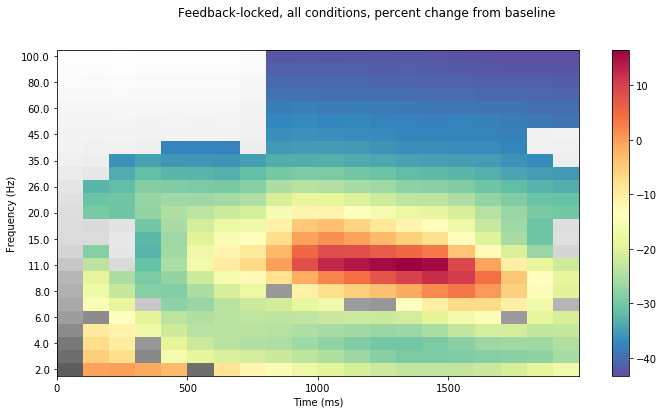

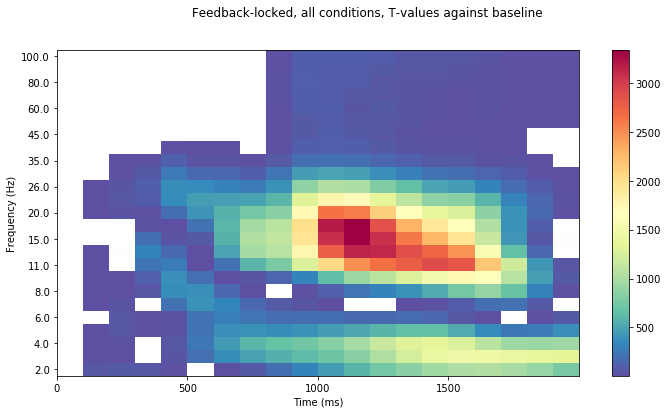

In [177]:
step = 2; freqs=fdbk_tfrs[0].freqs
ticks = [r for r in range(0,len(freqs),step)]
intervals = [z for z in zip(np.round([(r*.1)+.001 for r in range(20)],3),np.round([(r*.1)+.1 for r in range(20)],3))]
data = np.power(10,np.vstack([np.nanmean(fdbk_avg.copy().crop(t[0],t[1]).data,-1) for t in intervals]).T)*100-100

fig,ax = plt.subplots(1,1,figsize=(12,6))
im = plot_masked_tfr(data,fdbk_m,ax,labels={'y':(ticks,freqs[::step]),'x':([-.5,4.5,9.5,14.5],[0,500,1000,1500])},kwargs={'aspect':.5})
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (ms)")
fig.suptitle("Feedback-locked, all conditions, percent change from baseline")
fig.colorbar(im, ax=ax);

fig,ax = plt.subplots(1,1,figsize=(12,6))
im = plot_masked_tfr(fdbk_T,fdbk_m,ax,labels={'y':(ticks,freqs[::step]),'x':([-.5,4.5,9.5,14.5],[0,500,1000,1500])},kwargs={'aspect':.5})
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (ms)")
fig.suptitle("Feedback-locked, all conditions, T-values against baseline")
fig.colorbar(im, ax=ax);

#### Snippets:

In [20]:
time_slice = lambda t,s: np.all([t>s[0],t<=s[1]],axis=0)
times = stim_tfrs[0][0].times
bsl_100 = all_data[:,:,:,time_slice(times,(-.2,-.1))]